#### Student Name:
#### Student ID:

# Assignment 9

### GAN, chroma (MIDI) and pix2pix

Instructions: 

* This notebook is an interactive assignment; please read and follow the instructions in each cell. 

* Cells that require your input (in the form of code or written response) will have 'Question #' above.

* After completing the assignment, please submit this notebook and printout as a PDF.


In this notebook we explore a style transfer application that tries to change the musical texture of a piece while maintaining the harmonic structure. In order to do so we train a pix2pix type of model that learns the relations between chroma and the musical texture (distribution of notes). For this purpose we extract chroma from MIDI data and learn a generator that complements the notes from a given texture. You can think about this as something similar to pix2pix that learns completion of image textures from a sketch that was mentioned in class. In the image GAN the contours for training are generated using an edge detection on a complete image.

# 1. Imports and Loading Data
Before running, please make sure to upload the following to your python directory
- reverse_pianoroll.py
- convert.py
- Classical_Music_Midi.zip and unzip it

In [1]:
import pretty_midi
import reverse_pianoroll
import convert
import librosa

In [2]:
import numpy as np
import sys

In [20]:
#all necessary imports: use pip install [library name] to add to environment
#this notebook was run in 2019 with tensorflow version 1.15. some functions may or may not work with tensorflow > 2.0

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from os import listdir
import glob

In [4]:
#add songs to data
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = []
    for f in files:
        try:
            data = pretty_midi.PrettyMIDI(f)
            song = data.get_piano_roll(fs=16)
            song = convert.forward(song)
            # song = np.transpose(song) #if your code matrices aren't working, try uncommenting this. the convert.py file might not be updated
            songs.append(song)
        except Exception as e:
            raise e           
    return songs

In [5]:
#custom function to extract chroma features from song
def get_chromas(songs):
    chromas = []
    for song in songs: 
        chroma = np.zeros(shape=(np.shape(song)[0], 12))
        for i in np.arange(np.shape(song)[0]): 
            for j in np.arange(78):
                if song[i][j] > 0:
                    chroma[i][np.mod(j,12)] += 1
        #print(np.shape(chroma))
        chromas.append(chroma)
                
    return chromas

In [6]:
songs = get_songs('./chordgan/Classical_Music_Midi/mozart')
chromas = get_chromas(songs)
print ("{} songs processed".format(len(songs)))
print ("{} chromas processed".format(len(chromas)))

21 songs processed
21 chromas processed


#### Exploring the song and chroma representations

Looking at a random song segment

In [8]:
song = songs[0]
np.shape(song)

(3809, 156)

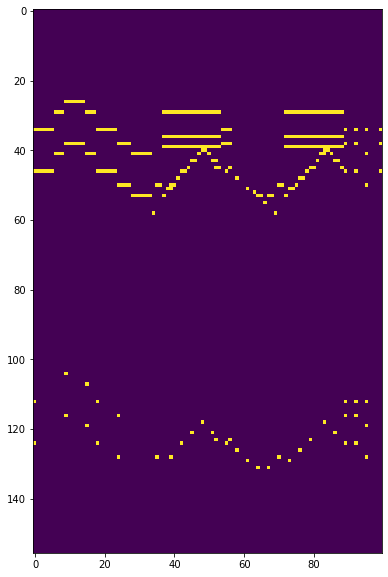

In [9]:
plt.figure(figsize = (20,10))
plt.imshow(100*song[:100,:].T)

In [10]:
chroma = chromas[0]
np.shape(chroma)

(3809, 12)

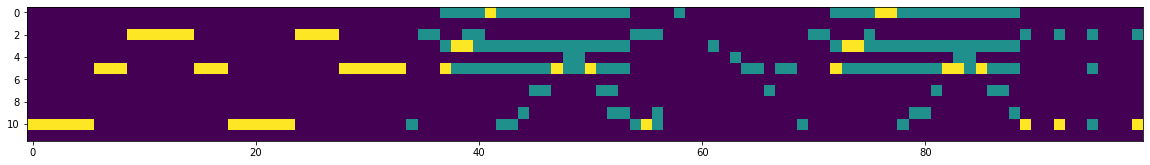

In [11]:
plt.figure(figsize = (20,10))
plt.imshow(100*chroma[:100,:].T)

##### Question 1 [10 points]
Describe what the chromas function does. In your answer refer to musical terms of note names and octave numbers. How does that resemble or differ from the chroma feature that is computed for audio spectrum? Use the figures to demonstrate the explanation.

Hint: Refresh the musical terms by looking at Slides 1 and consider what type of music anaylsis the audio chroma is used for. If you are interested more in musical theory you may also consider the concepts of "pitch class" and "music set theory" that are explained in https://en.wikipedia.org/wiki/Musical_note and https://en.wikipedia.org/wiki/Set_theory_%28music%29

``` your response here```

# 2. Setting Up GAN Model

In [12]:
lowest_note = 0 #the index of the lowest note on the piano roll
highest_note = 78 #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 4 #This is the number of timesteps that we will create at a time
X_dim = 2*note_range*num_timesteps #This is the size of the visible layer. 
Z_dim = 12*num_timesteps
n_hidden = 50 #This is the size of the hidden layer

print(X_dim,Z_dim)

624 48


##### Question 2 [10 points]

Explain what aspects of music (pitch, rhythm, note duration) are captured by the latent random Z? In your answer refer to the representaiton of the song data. Note how song matrix differs from standard pianoroll.

``` your response here```

In [13]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [15]:
#setting up model, discriminator weights and biases
X = tf.placeholder(tf.float32, shape=[None, X_dim])


D_W1 = tf.Variable(xavier_init([X_dim+Z_dim, 512]))
D_b1 = tf.Variable(tf.zeros(shape=[512]))

D_W2 = tf.Variable(xavier_init([512, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

In [16]:
#setting up model, generator weights and biases

#z is the space we're generating from
Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, X_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [17]:
def generator(z):
    G_h1 = tf.nn.relu(tf.matmul(z, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [18]:
def discriminator(x,c):
    D_h1 = tf.nn.relu(tf.matmul(tf.concat([x,c],1), D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

In [19]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.imshow(sample.reshape(78, 30), cmap='Greys_r')


    return fig

In [21]:
G_sample = generator(Z)

In [22]:
D_real, D_logit_real = discriminator(X,Z)

In [23]:
D_fake, D_logit_fake = discriminator(G_sample,Z)

##### Question 3 [10 points]
In standard GAN, the discriminator receives as input true or fake (generated) data only. Explain why in our case the disrciminator receives as input both the data and an additional variable Z? How this Z differs from the usual GAN input of a random vector?

``` your response here```

In [25]:

# Alternative losses:
# -------------------
Lambda = 100
D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake
G_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))
G_loss_L1 = tf.reduce_mean(tf.losses.mean_squared_error(X,G_sample))
G_loss = G_loss_fake + Lambda*G_loss_L1

##### Question 4 [10 points]
Explain the two components of the discriminator loss in the D_loss expression. Why the real loss uses tf.ones_like andthe fake loss uses tf.zeros_like in the cross entory loss? What are the statistical distributions (which datasets are used) in computational of the real and fake losses. In your answers you may either include an equation image or write the loss equaiton in latex mathamtical notation inside Markdown cell.

``` your response here ```

##### Question 5 [10 points]
In the generator loss G_loss we add an L1 loss. What does it represent? Why do you think we might want to add the L1 loss to the GAN model? We will explore this question further down the assignment, so at this point write down your best explanation based on the equations themselves without running any experiments.

``` your response here ```

In [26]:
#optimizing functions
D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)

In [27]:
#output midi file folder
if not os.path.exists('out/'):
    os.makedirs('out/')

In [29]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 3. Training GAN Model

In [31]:
i = 0
num_epochs = 200000
batch_size = 100
S_cutoff = 0.5
#commented out print statements output different losses, and plotting functions plot the piano roll and chroma.
while i <= num_epochs:
    for song, chroma in zip(songs, chromas):      
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements    
        song = np.array(song)     
        #print(np.shape(song))  
        song_steps = np.floor(song.shape[0]/num_timesteps).astype(int)
        song = song[:song_steps*num_timesteps]
        song = np.reshape(song, [song_steps, song.shape[1]*num_timesteps])  
        chroma = np.array(chroma)
        #print(np.shape(chroma)
        chroma = chroma[:song_steps*num_timesteps]
        chroma = np.reshape(chroma, [song_steps, chroma.shape[1]*num_timesteps])                
        batch_size = min(batch_size,len(song))
        # Train the RBM on batch_size examples at a time
        for ind in range(0, len(song), batch_size):       
            X_mb = song[ind:ind+batch_size]
            ch = chroma[ind:ind+batch_size]
#            _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb})
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: ch})
            _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={X: X_mb, Z: ch})
    
            if i % 1000 == 0:
                # print('Iter: {}'.format(i))
                dloss = ('D_Loss: {:.4}'. format(D_loss_curr))
                gloss = ('G_Loss: {:.4}'. format(G_loss_curr))
                print(dloss)
                print(gloss)
                
#             samples = sess.run(X_samples, feed_dict={z: np.random.randn(1,z_dim)})

                samples = sess.run(G_sample, feed_dict={Z: ch})
        
                S = np.reshape(samples, (ch.shape[0]*num_timesteps, 2*note_range))
                thresh_S = S>=S_cutoff

                thresh_S = np.transpose(thresh_S)


                C = np.reshape(ch, (ch.shape[0]*num_timesteps, 12))

                test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
                test.write('out/{}.mid'.format(i))

            i += 1

# 4. Style Transfer with a New Genre Dataset

In this part we will explore using the trained GAN to compose new music according to the harmonic structure of another musical input. In a way this comprises of a style transfer between the input music that belongs to style A and the output music that is generated using GAN trained on style B. In the example we will used J.S.Bach as our input (Style A) and output music in Mozart's style that was use to train our GAN (Style B). The new Mozart piece should follow the harmonic structure (chord progressions) of the Bach input.

In [36]:
#for testing, we will be using a different composer dataset to input into the generator here.
test_song = get_songs("./chordgan/Classical_Music_Midi/bach")
test_chromaz = get_chromas(test_song)
print ("{} songs processed".format(len(test_song)))
print ("{} songs processed".format(len(test_chromaz)))

3 songs processed
3 songs processed


In [37]:
#converted midi file folder
if not os.path.exists('converted/'):
    os.makedirs('converted/')

In [38]:
i = 0
S_cutoff = 0.5

for c in test_chromaz:
    test_chroma = np.array(c)
    

    test_chroma = test_chroma[:np.floor(test_chroma.shape[0]/num_timesteps).astype(int)*num_timesteps]
    test_chroma = np.reshape(test_chroma, [int(test_chroma.shape[0]/num_timesteps), test_chroma.shape[1]*num_timesteps])
    #chroma = np.reshape(chroma, [song_steps, chroma.shape[1]*num_timesteps])
       
    out_samples = sess.run(G_sample, feed_dict={Z: test_chroma})
    #print(np.shape(test_chroma),np.shape(samples))
    
    #print(np.floor(samples.shape[0]*samples.shape[1]/2/note_range).astype(int))
    
    S = np.reshape(out_samples, (np.floor(out_samples.shape[0]*out_samples.shape[1]/2/note_range).astype(int), 2*note_range))
    C = np.reshape(test_chroma, (test_chroma.shape[0]*num_timesteps, 12))
    #print(np.shape(S), np.shape(C))
    thresh_S = S>=S_cutoff
    thresh_S = np.transpose(thresh_S)


    
    # plt.figure(figsize=(30,18))
    # plt.subplot(1,2,1)
    # plt.imshow(S)
    # plt.subplot(1,2,2)
    # plt.imshow(C)
    # #plt.tight_layout()
    # plt.pause(0.1)


    test = reverse_pianoroll.piano_roll_to_pretty_midi(convert.back(thresh_S), fs=16)
    test.write('converted/{}.mid'.format(i))

    # midi_manipulation.noteStateMatrixToMidi(thresh_S, "new/generated_chord_{}".format(i))
    # i+=1  

##### Question 6 [10 points]
Open the conversion results in a musical MIDI software (such as Musescore) and observe/listen to the results. Write down your impressions about the quality of the musical texture style transfer - did the harmonic structure follow the Bach input? How did the notes distribution (choice of pitches and durations) change relative to the original Bach piece? Does the S_cutoff parameter affect the outcome, and if so, how? 

Summarize your findings and suggest some conclusions. Can you point to any musical aspects that were poorly modeled and ideas of improvement? 

``` your response here ```

# 5. Further experiments

##### Question 7 & 8: [total 40 points]

Choose two of the experiments and report their results:

1. Explore style transfer between more distant styles: For this purpose you may use the Pop_Music_Midi dataset and repeat the Style Transfer Experiment between Classical and Pop music (and vice versa). Report your findings in qualitative ways and submit the midi results together with your explanation. [20 Points]

2. Expermment with L1 distance: retrain the GAN model with very small and very large Lambda. What are the effects of such changes? When is the texture of the output more or less musical? Are the harmonic progressions of the input followed or ignored? Any other observations? [20 Points]

3. Create your own song: use the leadsheet2chroma.py file provided to create a Mozart style composition from your own leadsheet input. Provide the leadsheet in text format and the midi file results. Report your observations about the musical quality of the results. You may alter the leadsheet2chroma.py to fit other chords if you wish, or train GAN in a style different then Mozart. [20 Points]

